In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
#Import all the required libraries
import os
import time
import random
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import tensorflow_addons as tfa
print('Tensorflow version : ',tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE
import skimage
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from tensorflow_addons.image import rotate

Tensorflow version :  2.4.1


In [3]:
INPUT_MODEL="/kaggle/input/myoutput16042021/model/"

# Data understanding
Import the images & create two seperate datasets. The input shape for image should be (256, 256)

In [4]:
# Record start time
start_time=time.time()

In [5]:
# Define hyper parameters
IMG_HEIGHT=256
IMG_WIDTH=256
OUTPUT_CHANNELS=1
BUFFER_SIZE = 1000
BATCH_SIZE = 1

In [6]:
def add_gaussian_noise(img):
    common_type = tf.float32
    gnoise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.1, dtype=common_type)
    image_type_converted = tf.image.convert_image_dtype(img, dtype=common_type, saturate=False)
    noise_img = tf.add(image_type_converted, gnoise)
    return noise_img

In [7]:
'''
# Define method to decode and resize image
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=OUTPUT_CHANNELS)
    rnum = random.random()
    # Random left to right flip or add Gaussian Noise
    if rnum > 0.15:
        img = tf.image.adjust_brightness(img, 0.1)
    elif rnum > 0.3:
        img = tf.image.flip_left_right(img)
    elif rnum > 0.45:
        img = add_gaussian_noise(img)
    elif rnum > 0.6:
        img = tf.image.adjust_jpeg_quality(img, jpeg_quality=20)
    elif rnum > 0.9:
        img = tf.image.adjust_contrast(img, 0.2)
        
        img = rotate(img, tf.constant(np.pi/18))
    # resize the image to the desired size
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
'''

'\n# Define method to decode and resize image\ndef decode_img(img):\n    # convert the compressed string to a 3D uint8 tensor\n    img = tf.image.decode_jpeg(img, channels=OUTPUT_CHANNELS)\n    rnum = random.random()\n    # Random left to right flip or add Gaussian Noise\n    if rnum > 0.15:\n        img = tf.image.adjust_brightness(img, 0.1)\n    elif rnum > 0.3:\n        img = tf.image.flip_left_right(img)\n    elif rnum > 0.45:\n        img = add_gaussian_noise(img)\n    elif rnum > 0.6:\n        img = tf.image.adjust_jpeg_quality(img, jpeg_quality=20)\n    elif rnum > 0.9:\n        img = tf.image.adjust_contrast(img, 0.2)\n        \n        img = rotate(img, tf.constant(np.pi/18))\n    # resize the image to the desired size\n    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])\n'

In [8]:
# Define method to decode and resize image
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=OUTPUT_CHANNELS)

    # resize the image to the desired size
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [9]:
# Define method to decode and resize image
def decode_img_original_size(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=OUTPUT_CHANNELS)
    #img = tfa.image.mean_filter2d(img, filter_shape=11)
    return img

In [10]:
# Define method to read image from file, decode and resize calling decode_img method.
def process_path(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [11]:
# Define method to read image from file, decode and resize calling decode_img method.
def process_path_original_size(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img_original_size(img)
    return img

List of 5 file names from train images folder
b'/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Images/train/1.png'
b'/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Images/train/10.png'
b'/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Images/train/102.png'
b'/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Images/train/103.png'
b'/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Images/train/104.png'

Image shape:  (1300, 3100, 1)


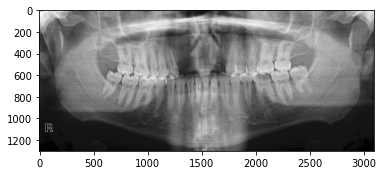

In [12]:
# Load the train images and create train dataset
TRAIN_IMAGE_DIR='/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Images/train/*.png'
list_train = tf.data.Dataset.list_files(TRAIN_IMAGE_DIR, shuffle=False)

print('List of 5 file names from train images folder')
for f in list_train.take(5):
    print(f.numpy())

original_train = list_train.map(process_path_original_size, num_parallel_calls=AUTOTUNE)
train = list_train.map(process_path, num_parallel_calls=AUTOTUNE)
for image in original_train.take(1):
    print("\nImage shape: ", image.numpy().shape)
    plt.imshow(image.numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    ORIG_HEIGHT = image.shape[0]
    ORIG_WIDTH = image.shape[1]

In [13]:
# Load the valid images and create valid dataset
VALID_IMAGE_DIR='/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Images/valid/*.png'
list_valid = tf.data.Dataset.list_files(VALID_IMAGE_DIR, shuffle=False)

In [14]:
# Load the test images and create test dataset
TEST_IMAGE_DIR='/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Images/test/*.png'
list_test = tf.data.Dataset.list_files(TEST_IMAGE_DIR, shuffle=False)

List of 5 file names from out images folder
b'/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Segmentation1/1.png'
b'/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Segmentation1/10.png'
b'/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Segmentation1/100.png'
b'/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Segmentation1/101.png'
b'/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Segmentation1/102.png'

Image shape:  (1300, 3100, 1)


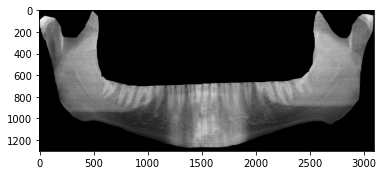

In [15]:
# Load the train images and create train dataset - out dataset
OUT_IMAGE_DIR='/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Segmentation1/*.png'
list_out = tf.data.Dataset.list_files(OUT_IMAGE_DIR, shuffle=False)

print('List of 5 file names from out images folder')
for f in list_out.take(5):
    print(f.numpy())

original_out = list_out.map(process_path_original_size, num_parallel_calls=AUTOTUNE)
out = list_out.map(process_path, num_parallel_calls=AUTOTUNE)
for image in original_out.take(1):
    print("\nImage shape: ", image.numpy().shape)
    plt.imshow(image.numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    ORIG_HEIGHT = image.shape[0]
    ORIG_WIDTH = image.shape[1]

In [16]:
# Check the shape of train dataset
train.element_spec

TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)

# Image Processing
1.Create a function to process your images with normalisation

2.Apply the function to both the datasets

3.Visualise the X-ray images after processing

In [17]:
# normalizing the images to [-1, 1] for tanh activation function
def normalize(image):
    image = (image / 127.5) - 1
    return image

In [18]:
# Method to flip image horizantally and then normalize image by calling normalize method.
def preprocess_image(image):
    #image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

In [19]:
# Process the train and out datasets
train = train.map(
    preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

out = out.map(
    preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [20]:
# Extract sample images from train and out datasets
sample_train = next(iter(train))
sample_out = next(iter(out))

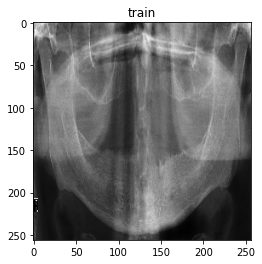

In [21]:
# Display sample image from train dataset
plt.title('train')
plt.imshow(sample_train[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

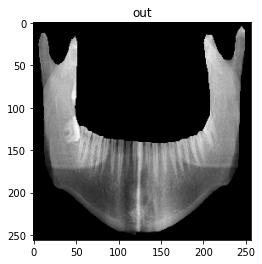

In [22]:
# Display sample image from out dataset
plt.title('out')
plt.imshow(sample_out[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

# Model Building & Training
The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

In [23]:
# Define class for Instance Normalization, methods for downsampling and upsampling
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [24]:
# Define method for unet_generator
def unet_generator():
    down_stack = [
        downsample(64, 4, apply_norm=False), # (bs, 128, 128, 64)
        downsample(128, 4, apply_norm=True), # (bs, 64, 64, 128)
        downsample(256, 4, apply_norm=True), # (bs, 32, 32, 256)
        downsample(512, 4, apply_norm=True), # (bs, 16, 16, 512)
        downsample(512, 4, apply_norm=True), # (bs, 8, 8, 512)
        downsample(512, 4, apply_norm=True), # (bs, 4, 4, 512)
        downsample(512, 4, apply_norm=True), # (bs, 2, 2, 512)
        downsample(512, 4, apply_norm=True)  # (bs, 1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4, apply_dropout=False), # (bs, 16, 16, 1024)
        upsample(256, 4, apply_dropout=False), # (bs, 32, 32, 512)
        upsample(128, 4, apply_dropout=False), # (bs, 64, 64, 256)
        upsample(64, 4, apply_dropout=False), # (bs, 128, 128, 128)
    ]
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', 
                                           kernel_initializer=initializer,
                                           activation='tanh') # (bs, 512, 512, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, OUTPUT_CHANNELS])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [25]:
# Instantiate g and f unet_generators
generator_g = unet_generator()
generator_f = unet_generator()

In [26]:
# Define discriminator method
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, OUTPUT_CHANNELS], name='input_image')
    x = inp
    down1 = downsample(64, 4, apply_norm=False)(x)   # (bs, 128, 128, 64)
    down2 = downsample(128, 4, apply_norm=True)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4, apply_norm=True)(down2) # (bs, 32, 32, 256)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=inp, outputs=last) #create the model using input & output layer


In [27]:
# Instantiate x and y discriminators for classifying tr1 and tr2 real vs fake images
discriminator_x = discriminator()
discriminator_y = discriminator()

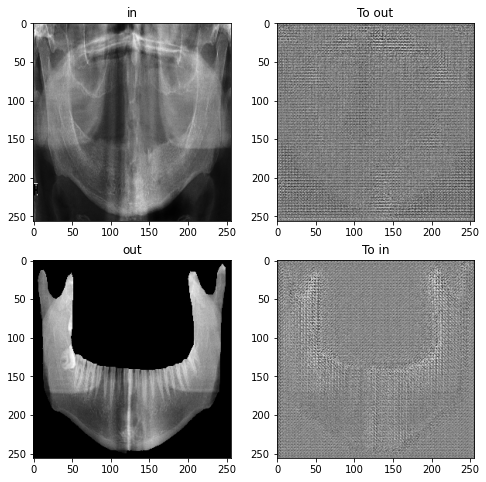

In [28]:
# Check the generator outputs for sample images
to_out = generator_g(sample_train)
to_in = generator_f(sample_out)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_train, to_out, sample_out, to_in]
title = ['in', 'To out', 'out', 'To in']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

In [29]:
# Define Lambda parameter
LAMBDA = 5

In [30]:
# Define loss object uisng BinaryCrossEntropy
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [31]:
# Define method to evaluate discriminator loss
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real),real) #write your code here
    generated_loss = loss_obj(tf.zeros_like(generated),generated)  #write your code here
    total_disc_loss = real_loss + generated_loss #write your code here
    return total_disc_loss * 0.5

In [32]:
# Define method to evaluate generator loss
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [33]:
# Define method to evaluate cycle loss
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image)) #write your code here
    return LAMBDA * loss1

In [34]:
# Define method to evaluate identity loss
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [35]:
# Define optimizer hyper parameters and optimizers for generators and discriminators
LEARNING_RATE=2e-4
BETA_1=0.5
BETA_2=0.999
EPSILON=1e-06

generator_g_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON
)
generator_f_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON
)

discriminator_x_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON
)
discriminator_y_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON
)

In [36]:
# Define number of epochs
EPOCHS = 750

In [37]:
# Define lists for plotting generator and discriminator losses
g_loss_per_epoch=[]
d_loss_per_epoch=[]
SSIM = 0
DSC = 0
PRE_SSIM = SSIM
PRE_DSC = DSC

In [38]:
MODELS_DIR='./model/'
!mkdir -p ./model

In [39]:
# Save models
def save_models(generator_g, generator_f, discriminator_x, discriminator_y, MODELS_DIR=MODELS_DIR):
    generator_g.save_weights(MODELS_DIR+"generator_g")
    generator_f.save_weights(MODELS_DIR+"generator_f")
    discriminator_x.save_weights(MODELS_DIR+"discriminator_x")
    discriminator_y.save_weights(MODELS_DIR+"discriminator_y")
    return True

In [40]:
# Load models
def load_models(generator_g, generator_f, discriminator_x, discriminator_y, INPUT_MODEL=INPUT_MODEL):
    generator_g.load_weights(INPUT_MODEL+"generator_g")
    generator_f.load_weights(INPUT_MODEL+"generator_f")
    discriminator_x.load_weights(INPUT_MODEL+"discriminator_x")
    discriminator_y.load_weights(INPUT_MODEL+"discriminator_y")
    return True

In [41]:
def dsc(inp, tgt):
    y_true_f = inp.flatten()
    y_pred_f = tgt.flatten()
    union = np.abs(np.sum(y_true_f)) + np.abs(np.sum(y_pred_f))
    if union==0: return 1
    intersection = np.abs(np.sum(y_true_f * y_pred_f))
    return 2. * intersection / union

In [42]:
# Define generate_images method to predict output from models and stores losses
def generate_images(model, test_input, expected_output,epoch=-1):
    global SSIM, DSC
    prediction = model(test_input)
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    if epoch != -1:
        g = generator_loss(prediction[0])
        d = discriminator_loss(test_input[0], prediction[0])
        g_loss_per_epoch.append(g.numpy())
        d_loss_per_epoch.append(d.numpy())
        
        inp = img_as_float(prediction[0])
        tgt = img_as_float(expected_output[0])
        mse_images = round(mean_squared_error(inp, tgt),4)
        #ssim_images = round(ssim(inp, tgt, data_range=tgt.max() - tgt.min(), multichannel=True),6)
        ssim_images = tf.image.ssim(inp, tgt, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
        dsc_images = dsc(inp, tgt)
        ssim_images = round(ssim_images.numpy(), 4)
        dsc_images = round(dsc_images, 4)
        
        is_print = False
        if (ssim_images > SSIM):
            SSIM = ssim_images
            ssim_label = ' SSIM:'
            is_print = True
        else:
            ssim_label = ' SSIM did not improve:'
        
        if (dsc_images > DSC):
            DSC = dsc_images
            dsc_label = ' DSC:'
            is_print = True
        else:
            dsc_label = ' DSC did not improve:'
            
        
        if is_print:
            print('Epoch :',epoch,'Generator Loss :',g.numpy(), ' Discriminator loss :',d.numpy(), 
                ' MSE:',mse_images, ssim_label ,ssim_images, dsc_label,dsc_images)
            save_models(generator_g, generator_f, discriminator_x, discriminator_y)
            plt.figure(figsize=(18, 20))
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.title(title[i])
                # getting the pixel values between [0, 1] to plot it.
                plt.imshow(tf.image.resize(display_list[i], [ORIG_HEIGHT, ORIG_WIDTH]).numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
                plt.axis('off')
            plt.show()
        else:  
            print('Epoch :',epoch,'Generator Loss :',g.numpy(), ' Discriminator loss :',d.numpy(), 
                ' MSE:',mse_images, ssim_label,ssim_images, dsc_label, dsc_images)
    else:         
        inp = img_as_float(prediction[0])
        tgt = img_as_float(expected_output[0])

        #ssim_images = round(ssim(inp, tgt, data_range=tgt.max() - tgt.min(), multichannel=True),6)
        ssim_images = tf.image.ssim(inp, tgt, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
        ssim_label = ' SSIM:' + str(ssim_images)
        print(ssim_label)
        
        dsc_images = dsc(inp, tgt)
        dsc_label = ' DSC:' + str(dsc_images)
        print(dsc_label)
        plt.figure(figsize=(18, 20))

        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # getting the pixel values between [0, 1] to plot it.
            plt.imshow(tf.image.resize(display_list[i], [ORIG_HEIGHT, ORIG_WIDTH]).numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
            plt.axis('off')
        plt.show()

In [43]:
# Define train step to train generator and discriminator models
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
    
        fake_y = generator_g(real_x)
        cycled_x = generator_f(fake_y)

        fake_x = generator_f(real_y)
        cycled_y = generator_g(fake_x)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x)
        same_y = generator_g(real_y)

        disc_real_x = discriminator_x(real_x)
        disc_real_y = discriminator_y(real_y)

        disc_fake_x = discriminator_x(fake_x)
        disc_fake_y = discriminator_y(fake_y)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
    
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

Epoch : 0 Generator Loss : 1.073457  Discriminator loss : 0.6212374  MSE: 0.2477  SSIM: 0.2785  DSC: 0.7572


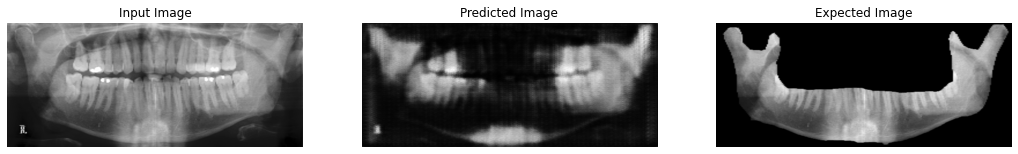

Epoch : 1 Generator Loss : 1.0734651  Discriminator loss : 0.621541  MSE: 0.0789  SSIM: 0.4626  DSC: 0.8954


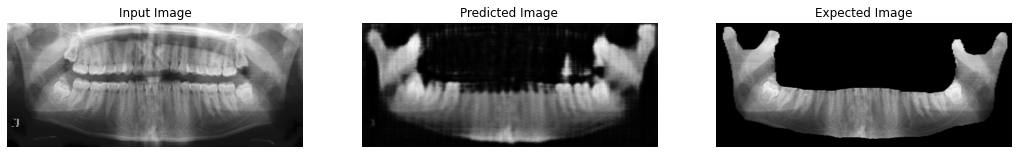

Epoch : 2 Generator Loss : 1.1267563  Discriminator loss : 0.6786821  MSE: 0.1002  SSIM did not improve: 0.4358  DSC did not improve: 0.8366
Epoch : 3 Generator Loss : 1.0754269  Discriminator loss : 0.62624955  MSE: 0.0831  SSIM: 0.5925  DSC: 0.9375


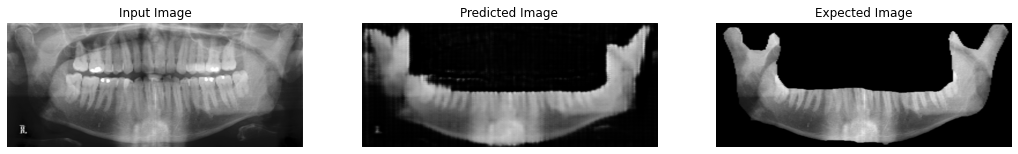

Epoch : 4 Generator Loss : 1.0832714  Discriminator loss : 0.6210332  MSE: 0.0933  SSIM did not improve: 0.4999  DSC did not improve: 0.9057
Epoch : 5 Generator Loss : 1.1486087  Discriminator loss : 0.6712969  MSE: 0.1059  SSIM did not improve: 0.4204  DSC did not improve: 0.8314
Epoch : 6 Generator Loss : 1.158349  Discriminator loss : 0.6694583  MSE: 0.1192  SSIM did not improve: 0.4705  DSC did not improve: 0.8322
Epoch : 7 Generator Loss : 1.1427929  Discriminator loss : 0.6686592  MSE: 0.0623  SSIM: 0.5995  DSC did not improve: 0.8818


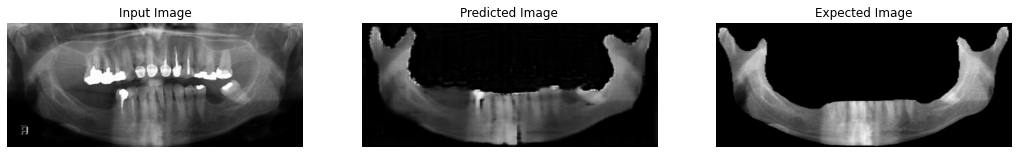

Epoch : 8 Generator Loss : 1.1603105  Discriminator loss : 0.6684432  MSE: 0.1223  SSIM did not improve: 0.4691  DSC did not improve: 0.8272
Epoch : 9 Generator Loss : 1.0868568  Discriminator loss : 0.6210574  MSE: 0.1322  SSIM did not improve: 0.5287  DSC did not improve: 0.8852
Epoch : 10 Generator Loss : 1.0912156  Discriminator loss : 0.61865246  MSE: 0.1688  SSIM did not improve: 0.4171  DSC did not improve: 0.8487
Epoch : 11 Generator Loss : 1.092231  Discriminator loss : 0.6195737  MSE: 0.1624  SSIM did not improve: 0.4161  DSC did not improve: 0.8344
Epoch : 12 Generator Loss : 1.1274152  Discriminator loss : 0.6780001  MSE: 0.1887  SSIM did not improve: 0.3991  DSC did not improve: 0.764
Epoch : 13 Generator Loss : 1.0814946  Discriminator loss : 0.62429523  MSE: 0.2159  SSIM did not improve: 0.4656  DSC did not improve: 0.8313
Epoch : 14 Generator Loss : 1.0974226  Discriminator loss : 0.6172955  MSE: 0.2524  SSIM did not improve: 0.3694  DSC did not improve: 0.7898
Epoch : 

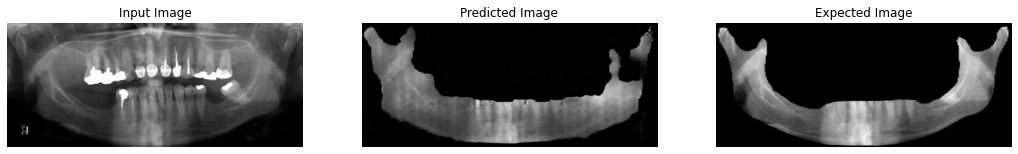

Epoch : 25 Generator Loss : 1.0854282  Discriminator loss : 0.6271661  MSE: 0.2056  SSIM did not improve: 0.4429  DSC did not improve: 0.8732
Epoch : 26 Generator Loss : 1.0377707  Discriminator loss : 0.63889354  MSE: 0.1185  SSIM: 0.6492  DSC did not improve: 0.9129


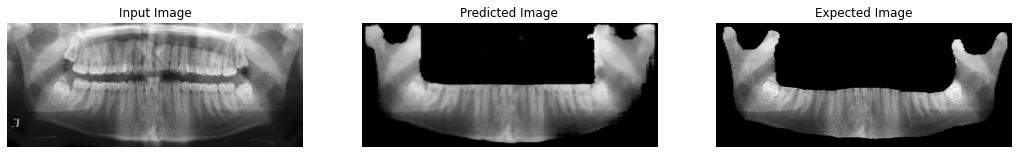

Epoch : 27 Generator Loss : 1.0699818  Discriminator loss : 0.6283964  MSE: 0.1025  SSIM did not improve: 0.531  DSC did not improve: 0.9242
Epoch : 28 Generator Loss : 1.0729842  Discriminator loss : 0.6302719  MSE: 0.0786  SSIM did not improve: 0.5983  DSC: 0.9689


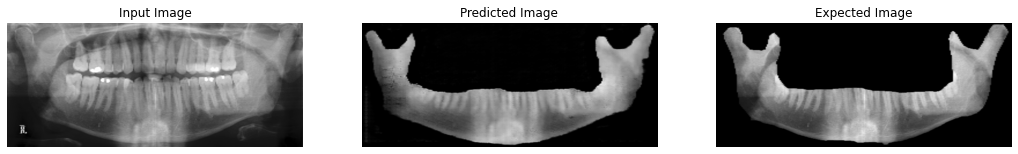

Epoch : 29 Generator Loss : 1.074913  Discriminator loss : 0.6274599  MSE: 0.1256  SSIM did not improve: 0.5402  DSC did not improve: 0.9112
Epoch : 30 Generator Loss : 1.0827914  Discriminator loss : 0.6255492  MSE: 0.1001  SSIM did not improve: 0.5695  DSC did not improve: 0.938
Epoch : 31 Generator Loss : 1.0839348  Discriminator loss : 0.6270822  MSE: 0.1277  SSIM did not improve: 0.5501  DSC did not improve: 0.9313
Epoch : 32 Generator Loss : 1.1574464  Discriminator loss : 0.6691751  MSE: 0.1495  SSIM did not improve: 0.4944  DSC did not improve: 0.8055
Epoch : 33 Generator Loss : 1.091147  Discriminator loss : 0.6211463  MSE: 0.1296  SSIM did not improve: 0.5432  DSC did not improve: 0.8992
Epoch : 34 Generator Loss : 1.0911384  Discriminator loss : 0.6230551  MSE: 0.1491  SSIM did not improve: 0.4558  DSC did not improve: 0.8696
Epoch : 35 Generator Loss : 1.1395313  Discriminator loss : 0.6714523  MSE: 0.0538  SSIM did not improve: 0.6314  DSC did not improve: 0.9003
Epoch : 3

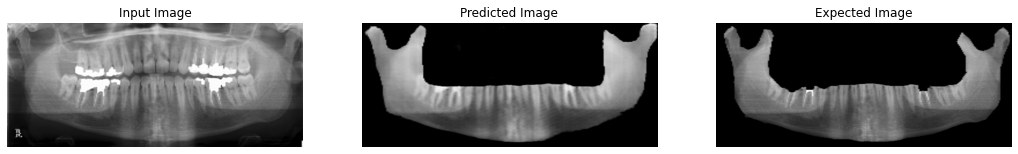

Epoch : 87 Generator Loss : 1.0739193  Discriminator loss : 0.62893593  MSE: 0.0741  SSIM did not improve: 0.6366  DSC did not improve: 0.9641
Epoch : 88 Generator Loss : 1.12198  Discriminator loss : 0.681952  MSE: 0.111  SSIM did not improve: 0.4915  DSC did not improve: 0.8427
Epoch : 89 Generator Loss : 1.140945  Discriminator loss : 0.6754081  MSE: 0.1458  SSIM did not improve: 0.5043  DSC did not improve: 0.8136
Epoch : 90 Generator Loss : 1.0936384  Discriminator loss : 0.6204874  MSE: 0.1205  SSIM did not improve: 0.6133  DSC did not improve: 0.9087
Epoch : 91 Generator Loss : 1.0912602  Discriminator loss : 0.6225132  MSE: 0.0821  SSIM did not improve: 0.6226  DSC did not improve: 0.9179
Epoch : 92 Generator Loss : 1.1392026  Discriminator loss : 0.67046314  MSE: 0.0343  SSIM did not improve: 0.6555  DSC did not improve: 0.9058
Epoch : 93 Generator Loss : 1.106464  Discriminator loss : 0.61891043  MSE: 0.1585  SSIM did not improve: 0.4833  DSC did not improve: 0.899
Epoch : 94

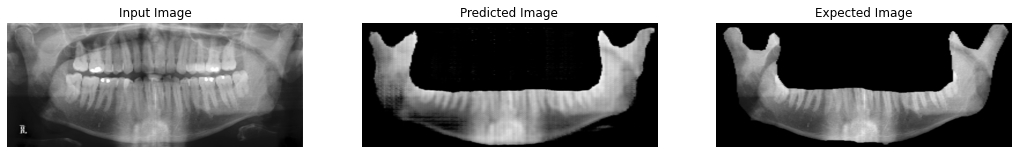

Epoch : 153 Generator Loss : 1.0985599  Discriminator loss : 0.61846197  MSE: 0.0626  SSIM did not improve: 0.6435  DSC did not improve: 0.9487
Epoch : 154 Generator Loss : 1.0672426  Discriminator loss : 0.63221574  MSE: 0.0657  SSIM did not improve: 0.6204  DSC: 0.981


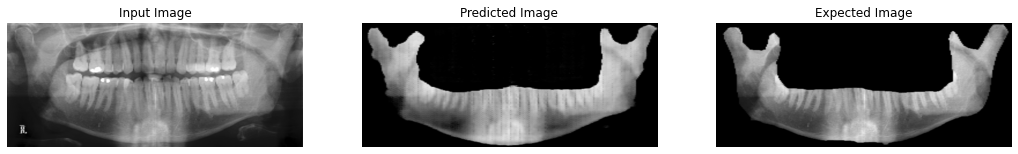

Epoch : 155 Generator Loss : 1.0719395  Discriminator loss : 0.6314397  MSE: 0.0681  SSIM did not improve: 0.6482  DSC: 0.9846


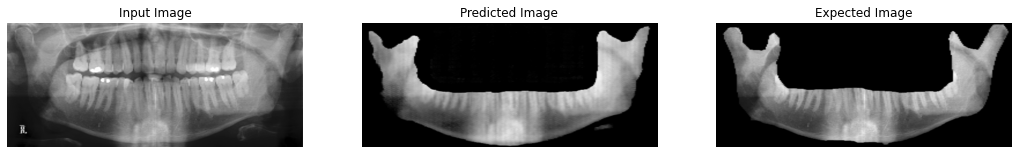

Epoch : 156 Generator Loss : 1.0818896  Discriminator loss : 0.6267921  MSE: 0.1024  SSIM did not improve: 0.5107  DSC did not improve: 0.9423
Epoch : 157 Generator Loss : 1.0721169  Discriminator loss : 0.63102865  MSE: 0.0815  SSIM did not improve: 0.5921  DSC did not improve: 0.9707
Epoch : 158 Generator Loss : 1.0614264  Discriminator loss : 0.6350939  MSE: 0.0947  SSIM did not improve: 0.4925  DSC did not improve: 0.9639
Epoch : 159 Generator Loss : 1.1208457  Discriminator loss : 0.68307763  MSE: 0.101  SSIM did not improve: 0.528  DSC did not improve: 0.8568
Epoch : 160 Generator Loss : 1.0908123  Discriminator loss : 0.62409925  MSE: 0.0783  SSIM did not improve: 0.5807  DSC did not improve: 0.9322
Epoch : 161 Generator Loss : 1.0874817  Discriminator loss : 0.62418866  MSE: 0.0846  SSIM did not improve: 0.618  DSC did not improve: 0.9514
Epoch : 162 Generator Loss : 1.1047575  Discriminator loss : 0.61646533  MSE: 0.0711  SSIM did not improve: 0.6672  DSC did not improve: 0.91

In [44]:
# Train the models for pre-defined number of epochs
#load_models(generator_g, generator_f, discriminator_x, discriminator_y)  # Load model for incremental training
for epoch in range(EPOCHS):
    for image_x, image_y in tf.data.Dataset.zip((train, out)):       
        train_step(image_x, image_y)

    list_test = tf.data.Dataset.list_files(TEST_IMAGE_DIR, shuffle=True)
    for f in list_test.take(1):
        f_target = '/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Segmentation1/'+str(f.numpy()).split('/')[7].split('\'')[0]

        list_img_in = tf.data.Dataset.list_files(f, shuffle=False)
        img_gen_in = list_img_in.map(process_path, num_parallel_calls=AUTOTUNE)
        img_gen_in = img_gen_in.map(
            preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(
            BUFFER_SIZE).batch(1)

        list_img_tg = tf.data.Dataset.list_files(f_target, shuffle=False)
        img_gen_tg = list_img_tg.map(process_path, num_parallel_calls=AUTOTUNE)
        img_gen_tg = img_gen_tg.map(
            preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(
            BUFFER_SIZE).batch(1)
    
        for inp in img_gen_in.take(1):
            for tgt in img_gen_tg.take(1):
                generate_images(generator_g, inp, tgt, epoch)

In [45]:
# Print the time taken for end to end execution
print('Time taken for execution :',round((time.time() - start_time)/60),'minutes')

Time taken for execution : 308 minutes


Text(0, 0.5, 'Loss')

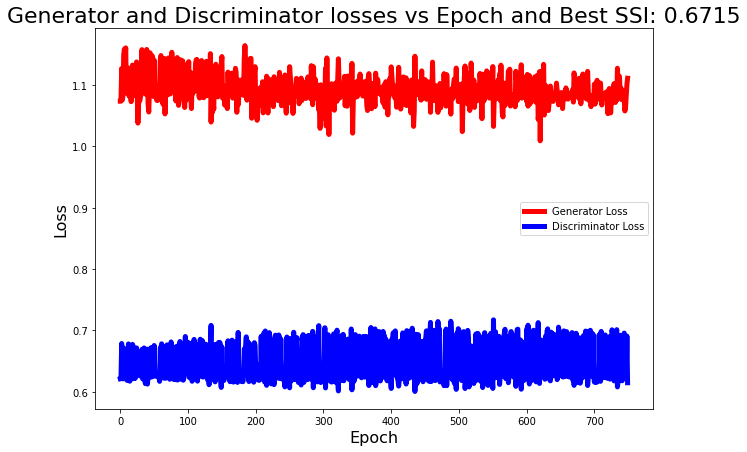

In [46]:
# Plot the generator and discriminator losses
epochs_list=list(range(EPOCHS))
plt.figure(figsize=(10,7))
plt.plot(epochs_list, g_loss_per_epoch, color='red',label='Generator Loss', linewidth=5, markersize=12)
plt.plot(epochs_list, d_loss_per_epoch, color='blue',label='Discriminator Loss', linewidth=5, markersize=12)
plt.legend()
plt.title('Generator and Discriminator losses vs Epoch'+' and Best SSI: '+str(SSIM), fontsize=22)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)

List of 5 file names from valid images folder
b'/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Images/valid/101.png'
 SSIM:tf.Tensor(0.5790603, shape=(), dtype=float32)
 DSC:0.9278844861235364


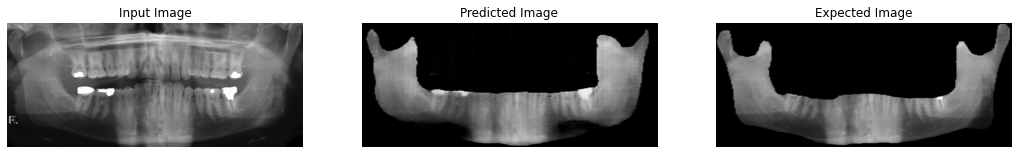

b'/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Images/valid/13.png'
 SSIM:tf.Tensor(0.6280822, shape=(), dtype=float32)
 DSC:0.9578808526480039


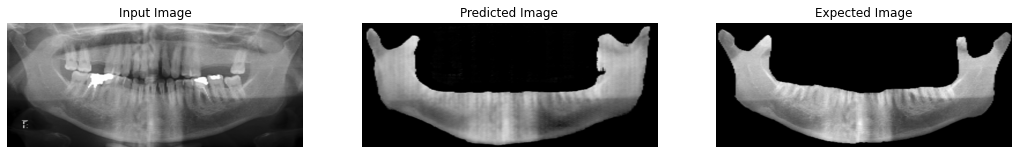

b'/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Images/valid/39.png'
 SSIM:tf.Tensor(0.6062856, shape=(), dtype=float32)
 DSC:0.979024253611076


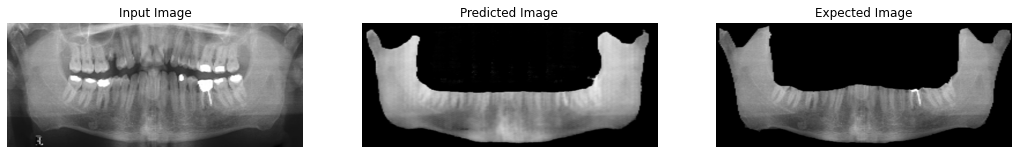

b'/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Images/valid/71.png'
 SSIM:tf.Tensor(0.6207965, shape=(), dtype=float32)
 DSC:0.9577796138238863


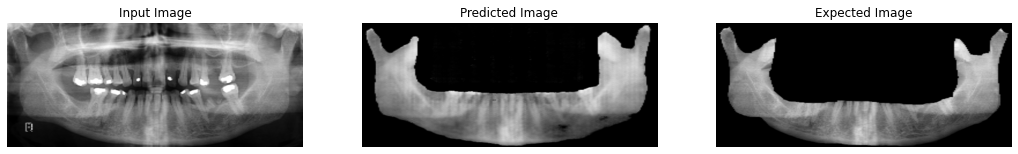

b'/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Images/valid/92.png'
 SSIM:tf.Tensor(0.54322886, shape=(), dtype=float32)
 DSC:0.9347804355836279


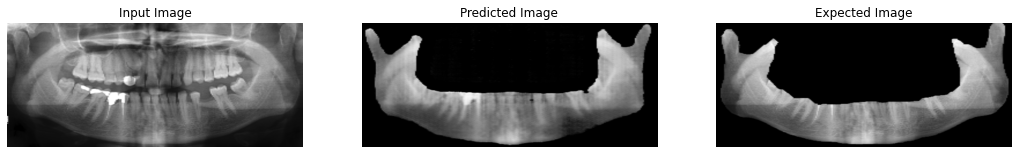

In [47]:
# Model results validation using validation set using model checkpoint with highest SSIM
print('List of 5 file names from valid images folder')

if PRE_SSIM == SSIM:  
    load_models(generator_g, generator_f, discriminator_x, discriminator_y,INPUT_MODEL)
else:
    load_models(generator_g, generator_f, discriminator_x, discriminator_y,MODELS_DIR)
    
for f in list_valid.take(5):
    print(f.numpy())

    f_target = '/kaggle/input/dental-xrays-train-valid-test-datasets/DentalPanoramicXrays_split/Segmentation1/'+str(f.numpy()).split('/')[7].split('\'')[0]

    list_img_in = tf.data.Dataset.list_files(f, shuffle=False)
    img_gen_in = list_img_in.map(process_path, num_parallel_calls=AUTOTUNE)
    img_gen_in = img_gen_in.map(
        preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(
        BUFFER_SIZE).batch(1)

    list_img_tg = tf.data.Dataset.list_files(f_target, shuffle=False)
    img_gen_tg = list_img_tg.map(process_path, num_parallel_calls=AUTOTUNE)
    img_gen_tg = img_gen_tg.map(
        preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(
        BUFFER_SIZE).batch(1)
    
    
    for inp in img_gen_in.take(1):
        for tgt in img_gen_tg.take(1):
            generate_images(generator_g, inp, tgt,-1)

In [48]:
! ls -ltr

total 2380
drwxr-xr-x 2 root root    4096 Jul  3 21:40 model
---------- 1 root root 2431606 Jul  4 01:43 __notebook__.ipynb


In [49]:
!ls -ltr ./model

total 446708
-rw-r--r-- 1 root root 217643656 Jul  3 21:40 generator_g.data-00000-of-00001
-rw-r--r-- 1 root root      3418 Jul  3 21:40 generator_g.index
-rw-r--r-- 1 root root 217643700 Jul  3 21:40 generator_f.data-00000-of-00001
-rw-r--r-- 1 root root      3418 Jul  3 21:40 generator_f.index
-rw-r--r-- 1 root root  11056151 Jul  3 21:40 discriminator_x.data-00000-of-00001
-rw-r--r-- 1 root root      1000 Jul  3 21:40 discriminator_x.index
-rw-r--r-- 1 root root  11056151 Jul  3 21:40 discriminator_y.data-00000-of-00001
-rw-r--r-- 1 root root      1000 Jul  3 21:40 discriminator_y.index
-rw-r--r-- 1 root root        87 Jul  3 21:40 checkpoint


In [50]:
!zip model_out.zip ./model/* 

  adding: model/checkpoint (deflated 39%)
  adding: model/discriminator_x.data-00000-of-00001 (deflated 7%)
  adding: model/discriminator_x.index (deflated 59%)
  adding: model/discriminator_y.data-00000-of-00001 (deflated 7%)
  adding: model/discriminator_y.index (deflated 59%)
  adding: model/generator_f.data-00000-of-00001 (deflated 7%)
  adding: model/generator_f.index (deflated 74%)
  adding: model/generator_g.data-00000-of-00001 (deflated 7%)
  adding: model/generator_g.index (deflated 74%)


In [51]:
!ls -ltr

total 416820
drwxr-xr-x 2 root root      4096 Jul  3 21:40 model
-rw-r--r-- 1 root root 424378558 Jul  4 01:44 model_out.zip
---------- 1 root root   2433989 Jul  4 01:44 __notebook__.ipynb
